____

# Accessibility Audit of MTR Stations
___

# About the project

This project generates an Accessibility Index to evaluate how well MTR stations serve elderly and disabled populations across Hong Kong. By analyzing the availability of barrier-free facilities against district-level demographic needs, the index aims to:

- Identifies priority stations requiring urgent accessibility upgrades
- Highlights facility gaps
- Guides equitable urban planning to align infrastructure with community needs

**Data overview**

All data sourced from [Hong Kong Open Data](https://data.gov.hk/).

| Category | Source | Dataset |
|----------|--------|---------------|
|MTR barrier-free facilities| [CSV](https://data.gov.hk/en-data/dataset/mtr-data-routes-fares-barrier-free-facilities) | (1) Free-barrier facilities available at each MTR station; (2) Barrier-free facility details; (3) MTR station details |
|2021 Population census data| [API](https://data.gov.hk/en-data/dataset/hk-censtatd-census_geo-2021-population-census-by-dcd/resource/dd44d37e-85c7-49b7-b485-644db561cf80) | Hong Kong population by age group and district |
|GeoCommunity database | [CSV](https://data.gov.hk/en-data/dataset/hk-landsd-openmap-development-hkms-digital-geocom) | MTR station location |

**Index methodology**

1. Facility availability scoring: Weighted points for each facilities based on criticality
2. Area need adjustment scoring: Adjusted points based on facility availability score and %elderly population

# 1. Import required packages

In [147]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import requests
import json

# 2. Data cleaning & transformation

## 2.1. MTR barrier-free facilities

- `barrier_free_facility` contains records of accessibility features (elevators, ramps, etc.) available at each station
- `barrier_free_facility_category` provides standardized classifications for accessibility facilities
- `barrier_free_facility_scorecard` is a custom-developed dataset assigning weighted scores to each facility type based on its importance for elderly/disabled passengers (e.g., elevators = 3 points).
- `mtr_lines_and_stations` contains information on MTR stations and their code, enhancing the comprehensibility of the `barrier_free_facility` dataset

*All datasets except the scorecard originate from Hong Kong open data portal.*

In [2]:
barrier_free_facility = pd.read_csv('data/raw/barrier_free_facilities.csv')
barrier_free_facility_category = pd.read_csv('data/raw/barrier_free_facility_category.csv')
barrier_free_facility_scorecard = pd.read_csv('data/raw/barrier_free_facility_scorecard.csv')
mtr_lines_and_stations = pd.read_csv('data/raw/mtr_lines_and_stations.csv')

### Barrier free facility 

In [3]:
barrier_free_facility.head()

,Station_No,Key,Value,AJTextEn,AJTextZh,Exit_Coordinate_X_Y
0,117,AJ1,N,NaN,NaN,NaN
1,117,AJ2,Y,Exit B2,B2 出口,NaN
2,117,AJ3,Y,Exit A,A 出口,NaN
3,117,AJ4,N,NaN,NaN,NaN
4,117,AJ5,N,NaN,NaN,NaN


In [4]:
barrier_free_facility = barrier_free_facility.rename(columns={'Key': 'barrier_free_facility_id',
                                                              'Value' : 'is_available',
                                                              'AJTextEn' : 'exit_location_en',
                                                              'AJTextZh' : 'exit_location_ch'})

In [5]:
barrier_free_facility.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3564 entries, 0 to 3563
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Station_No                3564 non-null   int64  
 1   barrier_free_facility_id  3564 non-null   object 
 2   is_available              3564 non-null   object 
 3   exit_location_en          165 non-null    object 
 4   exit_location_ch          165 non-null    object 
 5   Exit_Coordinate_X_Y       0 non-null      float64
dtypes: float64(1), int64(1), object(4)
memory usage: 167.2+ KB


In [6]:
barrier_free_facility.drop(columns=['Exit_Coordinate_X_Y'], inplace = True)

In [7]:
# Check for missing values in locations of facilities in case facitilities are available at the station

# 90% of the data is missing for the exit location --> drop the column
barrier_free_facility[(barrier_free_facility['is_available'] == 'Y') & (barrier_free_facility['exit_location_en'].isnull())]

,Station_No,barrier_free_facility_id,is_available,exit_location_en,exit_location_ch
7,117,AJ8,Y,NaN,NaN
9,117,HIn1,Y,NaN,NaN
10,117,HJ1,Y,NaN,NaN
11,117,HJ2,Y,NaN,NaN
13,117,HJ4,Y,NaN,NaN
...,...,...,...,...,...
3559,94,VJ4,Y,NaN,NaN
3560,94,VJ5,Y,NaN,NaN
3561,94,VJ6,Y,NaN,NaN
3562,94,VJ7,Y,NaN,NaN


In [8]:
barrier_free_facility.drop(columns=['exit_location_en', 'exit_location_ch'], inplace = True)

### Barrier free facility category

In [ ]:
barrier_free_facility_category.head()

,Item_Code,Category_Id,Category_En,Category_Zh,Facility_En,Facility_Zh,Sorting_Order
0,VJ1,VJ,Facilities for Visually Impaired,視覺受損人士設施,Tactile Guide Paths,失明人士引導徑,1
1,VJ2,VJ,Facilities for Visually Impaired,視覺受損人士設施,Escalator Audible Warning Signals,扶手電梯發聲提示器,2
2,VJ3,VJ,Facilities for Visually Impaired,視覺受損人士設施,Platform Tactile Yellow Lines,月台黃色凸條,3
3,VJ4,VJ,Facilities for Visually Impaired,視覺受損人士設施,Audible Device,發聲器,4
4,VJ5,VJ,Facilities for Visually Impaired,視覺受損人士設施,Braille,點字板,5
5,VJ6,VJ,Facilities for Visually Impaired,視覺受損人士設施,Colour Contrast Grab Poles,色彩分明的扶手桿,6
6,VJ7,VJ,Facilities for Visually Impaired,視覺受損人士設施,Buzzer,蜂鳴聲,7
7,VJ8,VJ,Facilities for Visually Impaired,視覺受損人士設施,Colour Contrast Inter-Car Barriers,色彩鮮明的欄障,8
8,VIn1,VJ,Facilities for Visually Impaired,視覺受損人士設施,Tactile Station Layout Maps,觸覺車站佈置圖,9
9,VIn2,VJ,Facilities for Visually Impaired,視覺受損人士設施,Modification of Obstructions,改裝障礙物,10


In [10]:
barrier_free_facility_category.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Item_Code      36 non-null     object
 1   Category_Id    36 non-null     object
 2   Category_En    36 non-null     object
 3   Category_Zh    36 non-null     object
 4   Facility_En    36 non-null     object
 5   Facility_Zh    36 non-null     object
 6   Sorting_Order  36 non-null     int64 
dtypes: int64(1), object(6)
memory usage: 2.1+ KB


In [11]:
# Rename Item_Code to Facility_Id for consistency
barrier_free_facility_category.rename(columns={'Item_Code': 'Facility_Id'}, inplace=True)

### Barrier free facility scorecard

In [12]:
barrier_free_facility_scorecard.head()

,Item_Code,Facility_En,Tier,Points,Rationale
0,VJ1,Tactile Guide Paths,1,3,Essential for visually impaired navigation
1,VJ2,Escalator Audible Warning Signals,2,2,Important safety feature for visually impaired
2,VJ3,Platform Tactile Yellow Lines,1,3,Critical safety feature at platform edges
3,VJ4,Audible Device,2,2,Important for audio announcements
4,VJ5,Braille,2,2,Important for blind passengers


In [13]:
barrier_free_facility_scorecard.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Item_Code    36 non-null     object
 1   Facility_En  36 non-null     object
 2   Tier         36 non-null     int64 
 3   Points       36 non-null     int64 
 4   Rationale    36 non-null     object
dtypes: int64(2), object(3)
memory usage: 1.5+ KB


In [14]:
# Rename Item_Code to Facility_Id for consistency
barrier_free_facility_scorecard.rename(columns={'Item_Code': 'Facility_Id'}, inplace=True)

### MTR lines and stations

In [15]:
mtr_lines_and_stations.head()

,Line Code,Direction,Station Code,Station ID,Chinese Name,English Name,Sequence
0,AEL,DT,AWE,56.0,博覽館,AsiaWorld-Expo,1.0
1,AEL,DT,AIR,47.0,機場,Airport,2.0
2,AEL,DT,TSY,46.0,青衣,Tsing Yi,3.0
3,AEL,DT,KOW,45.0,九龍,Kowloon,4.0
4,AEL,DT,HOK,44.0,香港,Hong Kong,5.0


In [16]:
mtr_lines_and_stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Line Code     270 non-null    object 
 1   Direction     270 non-null    object 
 2   Station Code  270 non-null    object 
 3   Station ID    270 non-null    float64
 4   Chinese Name  270 non-null    object 
 5   English Name  270 non-null    object 
 6   Sequence      270 non-null    float64
dtypes: float64(2), object(5)
memory usage: 15.1+ KB


In [ ]:
mtr_lines_and_stations.dropna(axis=0, how='all', inplace=True)

In [ ]:
# Extract data on MTR station only, leaving out information on Line
mtr_stations = mtr_lines_and_stations[['Station ID', 'Station Code', 'English Name']].drop_duplicates(keep='first')
mtr_stations

,Station ID,Station Code,English Name
0,56.0,AWE,AsiaWorld-Expo
1,47.0,AIR,Airport
2,46.0,TSY,Tsing Yi
3,45.0,KOW,Kowloon
4,44.0,HOK,Hong Kong
...,...,...,...
241,3.0,TST,Tsim Sha Tsui
261,86.0,OCP,Ocean Park
262,87.0,WCH,Wong Chuk Hang
263,88.0,LET,Lei Tung


### Merge tables

In [ ]:
# Merge all 4 dataframes to get a comprehensive view of barrier-free facilities
barrier_free_facility_details = barrier_free_facility \
    .merge(barrier_free_facility_category, how='left', left_on='barrier_free_facility_id', right_on='Facility_Id') \
    .merge(mtr_stations, how='left', left_on='Station_No', right_on='Station ID') \
    .merge(barrier_free_facility_scorecard, how='left', left_on='barrier_free_facility_id', right_on='Facility_Id')
    
# Drop unnecessary columns
barrier_free_facility_details.drop(columns=['Facility_Id_x', 'Facility_Id_y', 'Category_Zh', 'Facility_Zh', 'Sorting_Order', 'Station ID',
                                            'Facility_En_x', 'Facility_En_y'],
                                   inplace=True)

barrier_free_facility_details

,Station_No,barrier_free_facility_id,is_available,Category_Id,Category_En,Station Code,English Name,Tier,Points,Rationale
0,117,AJ1,N,AJ,System Accessibility,LOP,Long Ping,1,3,Critical for wheelchair boarding
1,117,AJ2,Y,AJ,System Accessibility,LOP,Long Ping,2,2,Important accessibility feature
2,117,AJ3,Y,AJ,System Accessibility,LOP,Long Ping,1,3,Essential for station access
3,117,AJ4,N,AJ,System Accessibility,LOP,Long Ping,2,2,Important but less reliable
4,117,AJ5,N,AJ,System Accessibility,LOP,Long Ping,2,2,Important alternative to elevators
...,...,...,...,...,...,...,...,...,...,...
3559,94,VJ4,Y,VJ,Facilities for Visually Impaired,EXC,Exhibition Centre,2,2,Important for audio announcements
3560,94,VJ5,Y,VJ,Facilities for Visually Impaired,EXC,Exhibition Centre,2,2,Important for blind passengers
3561,94,VJ6,Y,VJ,Facilities for Visually Impaired,EXC,Exhibition Centre,3,1,Helpful but not critical
3562,94,VJ7,Y,VJ,Facilities for Visually Impaired,EXC,Exhibition Centre,1,3,Emergency communication essential


In [20]:
barrier_free_facility_details.rename(columns={'barrier_free_facility_id': 'facility_id',
                                              'Station_No': 'station_no',
                                              'Category_Id': 'facility_category_id',
                                              'Category_En': 'facility_category_en',
                                              'Facility_En': 'facility_en',
                                              'Station Code': 'station_code',
                                              'English Name': 'station_name_en',
                                              'Tier': 'tier',
                                              'Points': 'point',
                                              'Rationale': 'rationale'}, 
                                     inplace=True)

In [21]:
barrier_free_facility_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3564 entries, 0 to 3563
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   station_no            3564 non-null   int64 
 1   facility_id           3564 non-null   object
 2   is_available          3564 non-null   object
 3   facility_category_id  3564 non-null   object
 4   facility_category_en  3564 non-null   object
 5   station_code          3492 non-null   object
 6   station_name_en       3492 non-null   object
 7   tier                  3564 non-null   int64 
 8   point                 3564 non-null   int64 
 9   rationale             3564 non-null   object
dtypes: int64(3), object(7)
memory usage: 278.6+ KB


In [22]:
# Check rows with missing values in station name and station code
barrier_free_facility_details[barrier_free_facility_details.isna().any(axis=1)]

,station_no,facility_id,is_available,facility_category_id,facility_category_en,station_code,station_name_en,tier,point,rationale
2196,70,AJ1,N,AJ,System Accessibility,NaN,NaN,1,3,Critical for wheelchair boarding
2197,70,AJ2,N,AJ,System Accessibility,NaN,NaN,2,2,Important accessibility feature
2198,70,AJ3,N,AJ,System Accessibility,NaN,NaN,1,3,Essential for station access
2199,70,AJ4,N,AJ,System Accessibility,NaN,NaN,2,2,Important but less reliable
2200,70,AJ5,Y,AJ,System Accessibility,NaN,NaN,2,2,Important alternative to elevators
...,...,...,...,...,...,...,...,...,...,...
3379,888,VJ4,N,VJ,Facilities for Visually Impaired,NaN,NaN,2,2,Important for audio announcements
3380,888,VJ5,N,VJ,Facilities for Visually Impaired,NaN,NaN,2,2,Important for blind passengers
3381,888,VJ6,N,VJ,Facilities for Visually Impaired,NaN,NaN,3,1,Helpful but not critical
3382,888,VJ7,N,VJ,Facilities for Visually Impaired,NaN,NaN,1,3,Emergency communication essential


In [23]:
# Drop rows with NA station
barrier_free_facility_details.dropna(subset=['station_name_en', 'station_code'], inplace=True)

barrier_free_facility_details

,station_no,facility_id,is_available,facility_category_id,facility_category_en,station_code,station_name_en,tier,point,rationale
0,117,AJ1,N,AJ,System Accessibility,LOP,Long Ping,1,3,Critical for wheelchair boarding
1,117,AJ2,Y,AJ,System Accessibility,LOP,Long Ping,2,2,Important accessibility feature
2,117,AJ3,Y,AJ,System Accessibility,LOP,Long Ping,1,3,Essential for station access
3,117,AJ4,N,AJ,System Accessibility,LOP,Long Ping,2,2,Important but less reliable
4,117,AJ5,N,AJ,System Accessibility,LOP,Long Ping,2,2,Important alternative to elevators
...,...,...,...,...,...,...,...,...,...,...
3559,94,VJ4,Y,VJ,Facilities for Visually Impaired,EXC,Exhibition Centre,2,2,Important for audio announcements
3560,94,VJ5,Y,VJ,Facilities for Visually Impaired,EXC,Exhibition Centre,2,2,Important for blind passengers
3561,94,VJ6,Y,VJ,Facilities for Visually Impaired,EXC,Exhibition Centre,3,1,Helpful but not critical
3562,94,VJ7,Y,VJ,Facilities for Visually Impaired,EXC,Exhibition Centre,1,3,Emergency communication essential


In [24]:
# Convert yes/no values to boolean
barrier_free_facility_details['is_available'].replace({'Y': True, 'N': False}, inplace=True)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_32252\1047034746.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  barrier_free_facility_details['is_available'].replace({'Y': True, 'N': False}, inplace=True)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_32252\1047034746.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_down

## 2.2. Population by age and district

### Import data from Census API

In [ ]:
# Read data from Census API
census_url = "https://idds.census2021.gov.hk/api/query?cv.AGE=0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-10000&cv.AREA=11,12,13,14,27,23,24,25,26,31,32,33,34,35,36,37,38,39&sv.RP=RP_NPER&period=2021&lang=en"

response = requests.get(census_url)
census_data = response.json()

In [ ]:
# Check the structure of the data
census_data['dataSet'][0:3]

[{'year': 2021,
  'svCode': 'RP',
  'svDesc': 'Population',
  'spCode': 'RP_NPER',
  'spDesc': 'Number of Persons',
  'ccList': [{'ccCode': '11',
    'ccDesc': 'Central and Western',
    'cvCode': 'AREA',
    'cvDesc': 'Area - for example : District Council District, New Town'},
   {'ccCode': '0-4', 'ccDesc': '0 - 4', 'cvCode': 'AGE', 'cvDesc': 'Age'}],
  'unit': 'Persons',
  'figure': '7583'},
 {'year': 2021,
  'svCode': 'RP',
  'svDesc': 'Population',
  'spCode': 'RP_NPER',
  'spDesc': 'Number of Persons',
  'ccList': [{'ccCode': '11',
    'ccDesc': 'Central and Western',
    'cvCode': 'AREA',
    'cvDesc': 'Area - for example : District Council District, New Town'},
   {'ccCode': '10-14', 'ccDesc': '10 - 14', 'cvCode': 'AGE', 'cvDesc': 'Age'}],
  'unit': 'Persons',
  'figure': '8192'},
 {'year': 2021,
  'svCode': 'RP',
  'svDesc': 'Population',
  'spCode': 'RP_NPER',
  'spDesc': 'Number of Persons',
  'ccList': [{'ccCode': '11',
    'ccDesc': 'Central and Western',
    'cvCode': 'AR

### Transformation: Convert JSON data to Dataframe

In [ ]:
census_df = pd.json_normalize(census_data['dataSet'])
census_df['id'] = range(1, len(census_df) + 1)
census_df

,year,svCode,svDesc,spCode,spDesc,ccList,unit,figure,id
0,2021,RP,Population,RP_NPER,Number of Persons,"[{'ccCode': '11', 'ccDesc': 'Central and Weste...",Persons,7583,1
1,2021,RP,Population,RP_NPER,Number of Persons,"[{'ccCode': '11', 'ccDesc': 'Central and Weste...",Persons,8192,2
2,2021,RP,Population,RP_NPER,Number of Persons,"[{'ccCode': '11', 'ccDesc': 'Central and Weste...",Persons,6989,3
3,2021,RP,Population,RP_NPER,Number of Persons,"[{'ccCode': '11', 'ccDesc': 'Central and Weste...",Persons,9790,4
4,2021,RP,Population,RP_NPER,Number of Persons,"[{'ccCode': '11', 'ccDesc': 'Central and Weste...",Persons,15723,5
...,...,...,...,...,...,...,...,...,...
319,2021,RP,Population,RP_NPER,Number of Persons,"[{'ccCode': '39', 'ccDesc': 'Islands', 'cvCode...",Persons,10149,320
320,2021,RP,Population,RP_NPER,Number of Persons,"[{'ccCode': '39', 'ccDesc': 'Islands', 'cvCode...",Persons,7376,321
321,2021,RP,Population,RP_NPER,Number of Persons,"[{'ccCode': '39', 'ccDesc': 'Islands', 'cvCode...",Persons,3652,322
322,2021,RP,Population,RP_NPER,Number of Persons,"[{'ccCode': '39', 'ccDesc': 'Islands', 'cvCode...",Persons,2646,323


In [ ]:
# Unnest ccList column

# Explode the list into separate rows
explored_ccList = census_df.explode('ccList')

# Expand dictionaries into columns
final_ccList = pd.concat(
    [explored_ccList.drop('ccList', axis=1), explored_ccList['ccList'].apply(pd.Series)],
    axis=1
)

final_ccList.drop(columns=['ccCode', 'cvCode', 'cvDesc'], inplace=True)
final_ccList

,year,svCode,svDesc,spCode,spDesc,unit,figure,id,ccDesc
0,2021,RP,Population,RP_NPER,Number of Persons,Persons,7583,1,Central and Western
0,2021,RP,Population,RP_NPER,Number of Persons,Persons,7583,1,0 - 4
1,2021,RP,Population,RP_NPER,Number of Persons,Persons,8192,2,Central and Western
1,2021,RP,Population,RP_NPER,Number of Persons,Persons,8192,2,10 - 14
2,2021,RP,Population,RP_NPER,Number of Persons,Persons,6989,3,Central and Western
...,...,...,...,...,...,...,...,...,...
321,2021,RP,Population,RP_NPER,Number of Persons,Persons,3652,322,75 - 79
322,2021,RP,Population,RP_NPER,Number of Persons,Persons,2646,323,Islands
322,2021,RP,Population,RP_NPER,Number of Persons,Persons,2646,323,80 - 84
323,2021,RP,Population,RP_NPER,Number of Persons,Persons,3473,324,Islands


In [ ]:
#Split the ccList into two separate dataframes
# One for area and one for age

final_ccList_area = final_ccList.iloc[range(0, len(final_ccList), 2)]
final_ccList_age = final_ccList.iloc[range(1, len(final_ccList), 2)]

# Merge the two dataframes back into the original census_df
census_df = census_df.merge(final_ccList_area, how='left', on='id') \
    .merge(final_ccList_age, how='left', on='id')

In [ ]:
# Drop unnecessary columns
population_area_age = census_df[['ccDesc_y', 'ccDesc_x', 'figure']]
population_area_age.rename(columns={'ccDesc_x': 'area', 
                          'ccDesc_y': 'age_group', 
                          'figure': 'population'}, inplace=True)

population_area_age

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_32252\1089992209.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  population_area_age.rename(columns={'ccDesc_x': 'area',


,age_group,area,population
0,0 - 4,Central and Western,7583
1,10 - 14,Central and Western,8192
2,15 - 19,Central and Western,6989
3,20 - 24,Central and Western,9790
4,25 - 29,Central and Western,15723
...,...,...,...
319,65 - 69,Islands,10149
320,70 - 74,Islands,7376
321,75 - 79,Islands,3652
322,80 - 84,Islands,2646


### Transformation: Population by area and age group

In [33]:
# Total population by area
population_area_age['population'] = population_area_age['population'].astype(int)
population_by_area = population_area_age.groupby('area')['population'].sum().reset_index()

population_by_area

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_32252\4292847676.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  population_area_age['population'] = population_area_age['population'].astype(int)


,area,population
0,Central and Western,235953
1,Eastern,529603
2,Islands,185282
3,Kowloon City,410634
4,Kwai Tsing,495798
5,Kwun Tong,673166
6,North,309631
7,Sai Kung,489037
8,Sha Tin,692806
9,Sham Shui Po,431090


In [ ]:
# Calculate population percentage for each age group and district (area)
population_area_age = population_area_age.merge(population_by_area, how='left', on='area', suffixes=('', '_total'))
population_area_age['population_percentage'] = population_area_age['population'] / population_area_age['population_total'] * 100

population_area_age

,age_group,area,population,population_total
0,0 - 4,Central and Western,7583,235953
1,10 - 14,Central and Western,8192,235953
2,15 - 19,Central and Western,6989,235953
3,20 - 24,Central and Western,9790,235953
4,25 - 29,Central and Western,15723,235953
...,...,...,...,...
319,65 - 69,Islands,10149,185282
320,70 - 74,Islands,7376,185282
321,75 - 79,Islands,3652,185282
322,80 - 84,Islands,2646,185282


### Transformation: Old population by area

In [ ]:
# Create a tag to identify age groups belonging to elderly population
old_age_group = ['65 - 69', '70 - 74', '75 - 79', '80 - 84', '85+']
population_area_age['is_old'] = population_area_age['age_group'].apply(lambda x: 1 if x in old_age_group else 0)

# Calculate the percentage of elderly population in each area
old_population_by_area = population_area_age[population_area_age['is_old']==True] \
    .groupby('area')['population_percentage'].sum().reset_index()
old_population_by_area.rename(columns={'population_percentage': 'old_population_percentage'}, inplace=True)

old_population_by_area

,area,old_population_percentage
0,Central and Western,19.279687
1,Eastern,23.358440
2,Islands,14.732138
3,Kowloon City,20.080656
4,Kwai Tsing,22.078750
5,Kwun Tong,21.947187
6,North,17.942971
7,Sai Kung,15.801054
8,Sha Tin,19.989001
9,Sham Shui Po,20.398293


## 2.3. MTR station location

In [37]:
geo_comm = pd.read_csv('data/raw/GeoCom4.0_202503.csv')
geo_comm.head()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_32252\3558920495.py:1: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  geo_comm = pd.read_csv('data/raw/GeoCom4.0_202503.csv')


,GEONAMEID,ENGLISHNAME,CHINESENAME,CLASS,TYPE,SUBCAT,EASTING,NORTHING,SOURCE,E_FLOOR,...,E_DISTRICT,C_DISTRICT,E_REGION,C_REGION,E_ADDRESS,C_ADDRESS,TEL_NO,FAX_NO,WEB_SITE,REV_DATE
0,21243310,CANADIAN INTERNATIONAL SCHOOL,加拿大國際學校,SCH,KDG,KDGCCC,835302.0,812017.0,1,G/F,...,Southern District,南區,HK,香港,"UNITS G21-G24, SITE C, NO. 11 HEUNG YIP ROAD, ...",香港黃竹坑香葉道11號THE SOUTHSIDE地下G21—24號舖,<Null>,<Null>,NaN,20/3/2025
1,21243324,HKCT Institute of Higher Education (Yuen Long ...,港專學院 (元朗教學中心),SCH,TEI,NaN,821301.0,833974.0,1,G/F,...,Yuen Long District,元朗區,NT,新界,"Shop No. 22, Ground Floor, Golden Plaza, 28 Sh...",新界元朗水車館街28號萬金中心地下22號鋪,<Null>,<Null>,NaN,20/3/2025
2,21243329,Hong Kong College of Technology (Kwun Tong Lea...,香港專業進修學校 (觀塘教學中心),SCH,TEI,NaN,841232.0,819122.0,1,8/F,...,Kwun Tong District,觀塘區,KLN,九龍,"Room 801 and 802, 8/F, Wong Tze Building, 71 H...",九龍觀塘開源道71號王子大廈8樓,<Null>,<Null>,NaN,20/3/2025
3,21243337,IBEL RUSY AND PURVIZ SHROFF CHARITABLE FOUNDAT...,匯成勞士施羅孚伉儷慈善基金幼稚園,SCH,KDG,KDGCCC,835381.0,818146.0,1,1/F,...,Yau Tsim Mong District,油尖旺區,KLN,九龍,"SHOPS 119-121, 1/F., VICTORIA MALL, 188 CANTON...",九龍尖沙咀廣東道188號港景滙商場1樓119—121號舖,<Null>,<Null>,NaN,20/3/2025
4,21243321,HKCT Institute of Higher Education (Kwun Tong ...,港專學院 (觀塘教學中心),SCH,TEI,NaN,841234.0,819121.0,1,8/F,...,Kwun Tong District,觀塘區,KLN,九龍,"Room 801 and 802, 8/F, Wong Tze Building, 71 H...",九龍觀塘開源道71號王子大廈8樓,<Null>,<Null>,NaN,20/3/2025


In [ ]:
# Filter for MTR stations only
mtr_station = geo_comm[(geo_comm['CLASS'] == 'TRS') & (geo_comm['TYPE'] == 'MTA')][['E_SITENAME', 'E_DISTRICT']]
mtr_station = mtr_station.drop_duplicates(keep = 'first').dropna().reset_index()

mtr_station

,index,E_SITENAME,E_DISTRICT
0,4437,Mass Transit Railway Lei Tung Station,Southern District
1,4652,Mass Transit Railway Lai King Station,Kwai Tsing District
2,4664,Mass Transit Railway Disneyland Resort Station,Tsuen Wan District
3,4713,Mass Transit Railway Ocean Park Station,Southern District
4,5274,Mass Transit Railway Tsing Yi Station,Kwai Tsing District
...,...,...,...
95,14971,Mass Transit Railway HKU Station,Central & Western District
96,14977,Mass Transit Railway Sha Tin Station,Sha Tin District
97,14996,Mass Transit Railway Tseung Kwan O Station,Sai Kung District
98,15121,Mass Transit Railway Fortress Hill Station,Eastern District


In [ ]:
# Clean the MTR station name and district name to match with the format from census data and barrier-free facility data
mtr_station['E_SITENAME'] = mtr_station['E_SITENAME'].str.replace(r'Mass Transit Railway | Station', '', regex=True).str.strip()
mtr_station['E_DISTRICT'] = mtr_station['E_DISTRICT'].str.replace('District', '') \
        .str.replace('&', 'and') \
        .str.strip()

mtr_station

,index,E_SITENAME,E_DISTRICT
0,4437,Lei Tung,Southern
1,4652,Lai King,Kwai Tsing
2,4664,Disneyland Resort,Tsuen Wan
3,4713,Ocean Park,Southern
4,5274,Tsing Yi,Kwai Tsing
...,...,...,...
95,14971,HKU,Central and Western
96,14977,Sha Tin,Sha Tin
97,14996,Tseung Kwan O,Sai Kung
98,15121,Fortress Hill,Eastern


In [40]:
mtr_station.rename(columns={'E_SITENAME': 'station_name_en', 'E_DISTRICT': 'area'}, inplace=True)

In [41]:
# Find stations that belong to 2 areas
mtr_station[['station_name_en', 'area']].drop_duplicates(keep='first').sort_values('station_name_en')

,station_name_en,area
44,Admiralty,Central and Western
86,Airport,Islands
75,AsiaWorld-Expo,Islands
76,Austin,Yau Tsim Mong
57,Causeway Bay,Wan Chai
...,...,...
62,Wong Tai Sin,Wong Tai Sin
26,Wu Kai Sha,Sha Tin
85,Yau Ma Tei,Yau Tsim Mong
12,Yau Tong,Kwun Tong


In [42]:
# Drop inaccurate rows
mtr_station = mtr_station[~((mtr_station['station_name_en'] == 'Choi Hung') & (mtr_station['area'] == 'Kwun Tong') |
              (mtr_station['station_name_en'] == 'Kowloon Tong') & (mtr_station['area'] == 'Sham Shui Po'))] \
    .reset_index()

## 2.4. Merge MTR barrier-free facility detail and elderly population data using MTR station location

In [43]:
barrier_free_facility_details = barrier_free_facility_details \
    .merge(mtr_station, how='left', on='station_name_en') \
    .merge(old_population_by_area, how='left', on='area')

In [44]:
barrier_free_facility_details

,station_no,facility_id,is_available,facility_category_id,facility_category_en,station_code,station_name_en,tier,point,rationale,level_0,index,area,old_population_percentage
0,117,AJ1,False,AJ,System Accessibility,LOP,Long Ping,1,3,Critical for wheelchair boarding,15,5633,Yuen Long,15.023051
1,117,AJ2,True,AJ,System Accessibility,LOP,Long Ping,2,2,Important accessibility feature,15,5633,Yuen Long,15.023051
2,117,AJ3,True,AJ,System Accessibility,LOP,Long Ping,1,3,Essential for station access,15,5633,Yuen Long,15.023051
3,117,AJ4,False,AJ,System Accessibility,LOP,Long Ping,2,2,Important but less reliable,15,5633,Yuen Long,15.023051
4,117,AJ5,False,AJ,System Accessibility,LOP,Long Ping,2,2,Important alternative to elevators,15,5633,Yuen Long,15.023051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3487,94,VJ4,True,VJ,Facilities for Visually Impaired,EXC,Exhibition Centre,2,2,Important for audio announcements,43,12026,Wan Chai,21.223792
3488,94,VJ5,True,VJ,Facilities for Visually Impaired,EXC,Exhibition Centre,2,2,Important for blind passengers,43,12026,Wan Chai,21.223792
3489,94,VJ6,True,VJ,Facilities for Visually Impaired,EXC,Exhibition Centre,3,1,Helpful but not critical,43,12026,Wan Chai,21.223792
3490,94,VJ7,True,VJ,Facilities for Visually Impaired,EXC,Exhibition Centre,1,3,Emergency communication essential,43,12026,Wan Chai,21.223792


# 3. Accessibility index calculation

Accessibility index is the summation of: 
1. Facility availability score: Weighted points for each facilities based on criticality
2. Area need adjustment score: Adjusted points based on facility availability score and %elderly population, following the table below:

![](images/index_prioritization_framework.png)

## 3.1. Facility availability score

In [45]:
# Calculate score for each facility based on availability and point
# If the facility is available, the score is equal to the point
# If the facility is not available, the score is 0

barrier_free_facility_details['facility_available_score'] = np.where(
    barrier_free_facility_details['is_available'],
    barrier_free_facility_details['point'],
    0
)

barrier_free_facility_details

,station_no,facility_id,is_available,facility_category_id,facility_category_en,station_code,station_name_en,tier,point,rationale,level_0,index,area,old_population_percentage,facility_available_score
0,117,AJ1,False,AJ,System Accessibility,LOP,Long Ping,1,3,Critical for wheelchair boarding,15,5633,Yuen Long,15.023051,0
1,117,AJ2,True,AJ,System Accessibility,LOP,Long Ping,2,2,Important accessibility feature,15,5633,Yuen Long,15.023051,2
2,117,AJ3,True,AJ,System Accessibility,LOP,Long Ping,1,3,Essential for station access,15,5633,Yuen Long,15.023051,3
3,117,AJ4,False,AJ,System Accessibility,LOP,Long Ping,2,2,Important but less reliable,15,5633,Yuen Long,15.023051,0
4,117,AJ5,False,AJ,System Accessibility,LOP,Long Ping,2,2,Important alternative to elevators,15,5633,Yuen Long,15.023051,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3487,94,VJ4,True,VJ,Facilities for Visually Impaired,EXC,Exhibition Centre,2,2,Important for audio announcements,43,12026,Wan Chai,21.223792,2
3488,94,VJ5,True,VJ,Facilities for Visually Impaired,EXC,Exhibition Centre,2,2,Important for blind passengers,43,12026,Wan Chai,21.223792,2
3489,94,VJ6,True,VJ,Facilities for Visually Impaired,EXC,Exhibition Centre,3,1,Helpful but not critical,43,12026,Wan Chai,21.223792,1
3490,94,VJ7,True,VJ,Facilities for Visually Impaired,EXC,Exhibition Centre,1,3,Emergency communication essential,43,12026,Wan Chai,21.223792,3


In [ ]:
#Widen the dataframe to get a score for each MTR station

indices = ['station_no', 'station_code', 'station_name_en', 'area', 'old_population_percentage']
station_score = barrier_free_facility_details.pivot_table(index = indices,
                                    columns = 'facility_category_en',
                                    values = 'facility_available_score',
                                    aggfunc = 'sum')
station_score = station_score.reset_index(names=indices)

station_score.rename(columns={'Facilities for Hearing Impaired' : 'hearing_impared_facility',
                              'Facilities for Mobility Impaired' : 'mobility_impared_facility',
                              'Facilities for Visually Impaired': 'visually_impaired_facility',
                              'System Accessibility': 'system_accessibility'}, inplace=True)
station_score

facility_category_en,station_no,station_code,station_name_en,area,old_population_percentage,hearing_impared_facility,mobility_impared_facility,visually_impaired_facilities,system_accessibility
0,1,CEN,Central,Central and Western,19.279687,6,10,18,6
1,2,ADM,Admiralty,Central and Western,19.279687,8,10,17,8
2,3,TST,Tsim Sha Tsui,Yau Tsim Mong,17.887828,6,9,20,8
3,4,JOR,Jordan,Yau Tsim Mong,17.887828,6,8,18,6
4,5,YMT,Yau Ma Tei,Yau Tsim Mong,17.887828,6,10,18,8
...,...,...,...,...,...,...,...,...,...
92,116,YUL,Yuen Long,Yuen Long,15.023051,6,10,18,10
93,117,LOP,Long Ping,Yuen Long,15.023051,6,10,18,8
94,118,TIS,Tin Shui Wai,Yuen Long,15.023051,6,10,18,10
95,119,SIH,Siu Hong,Tuen Mun,19.325125,6,10,18,11


In [47]:
# Calculate total facility score for each station
facility_col = station_score.columns[5:].tolist()
station_score['total_facility_score'] = station_score[facility_col].sum(axis=1)

station_score

facility_category_en,station_no,station_code,station_name_en,area,old_population_percentage,hearing_impared_facility,mobility_impared_facility,visually_impaired_facilities,system_accessibility,total_facility_score
0,1,CEN,Central,Central and Western,19.279687,6,10,18,6,40
1,2,ADM,Admiralty,Central and Western,19.279687,8,10,17,8,43
2,3,TST,Tsim Sha Tsui,Yau Tsim Mong,17.887828,6,9,20,8,43
3,4,JOR,Jordan,Yau Tsim Mong,17.887828,6,8,18,6,38
4,5,YMT,Yau Ma Tei,Yau Tsim Mong,17.887828,6,10,18,8,42
...,...,...,...,...,...,...,...,...,...,...
92,116,YUL,Yuen Long,Yuen Long,15.023051,6,10,18,10,44
93,117,LOP,Long Ping,Yuen Long,15.023051,6,10,18,8,42
94,118,TIS,Tin Shui Wai,Yuen Long,15.023051,6,10,18,10,44
95,119,SIH,Siu Hong,Tuen Mun,19.325125,6,10,18,11,45


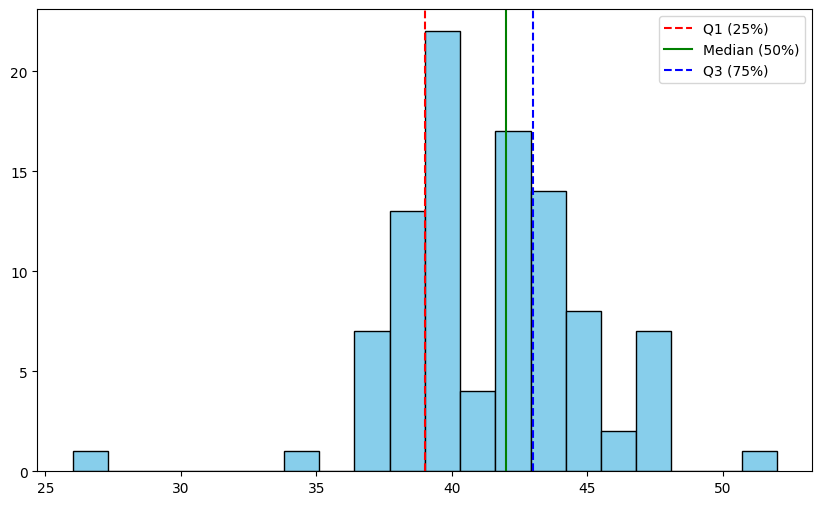

In [48]:
# Look into the distribution of the total facility score
plt.figure(figsize=(10,6))
plt.hist(station_score['total_facility_score'], bins = 20, color='skyblue', edgecolor='black')

# Add vertical lines for quartiles
q1, q2, q3 = station_score['total_facility_score'].quantile([0.25, 0.5, 0.75])
plt.axvline(q1, color='red', linestyle='--', label='Q1 (25%)')
plt.axvline(q2, color='green', linestyle='-', label='Median (50%)')
plt.axvline(q3, color='blue', linestyle='--', label='Q3 (75%)')

plt.legend()
plt.show()

In [49]:
# Check quartile values

print(f'''
Quartile Analysis:
- Q1 (25th percentile): {q1}
- Median (50th percentile): {q2}
- Q3 (75th percentile): {q3}
- Interquartile Range (IQR): {q3-q1}
''')


Quartile Analysis:
- Q1 (25th percentile): 39.0
- Median (50th percentile): 42.0
- Q3 (75th percentile): 43.0
- Interquartile Range (IQR): 4.0



In [ ]:
# Categorize the facility score into Low, Medium, or High based on quartiles.
def categorize_facility_score(row):
    """
    Categorize the facility score into Low, Medium, or High based on quartiles.
    If the score is less than Q1, it is Low
    If the score is between Q1 and Q3, it is Medium
    If the score is greater than Q3, it is High
    """
    if row['total_facility_score'] < q1:
        return 'Low'
    elif row['total_facility_score'] >= q3:
        return 'High'
    else:
        return 'Medium'

station_score['facility_score_category'] = station_score.apply(categorize_facility_score, axis=1)
station_score

facility_category_en,station_no,station_code,station_name_en,area,old_population_percentage,hearing_impared_facility,mobility_impared_facility,visually_impaired_facilities,system_accessibility,total_facility_score,facility_score_category
0,1,CEN,Central,Central and Western,19.279687,6,10,18,6,40,Medium
1,2,ADM,Admiralty,Central and Western,19.279687,8,10,17,8,43,High
2,3,TST,Tsim Sha Tsui,Yau Tsim Mong,17.887828,6,9,20,8,43,High
3,4,JOR,Jordan,Yau Tsim Mong,17.887828,6,8,18,6,38,Low
4,5,YMT,Yau Ma Tei,Yau Tsim Mong,17.887828,6,10,18,8,42,Medium
...,...,...,...,...,...,...,...,...,...,...,...
92,116,YUL,Yuen Long,Yuen Long,15.023051,6,10,18,10,44,High
93,117,LOP,Long Ping,Yuen Long,15.023051,6,10,18,8,42,Medium
94,118,TIS,Tin Shui Wai,Yuen Long,15.023051,6,10,18,10,44,High
95,119,SIH,Siu Hong,Tuen Mun,19.325125,6,10,18,11,45,High


## 3.2. Area need adjustment score

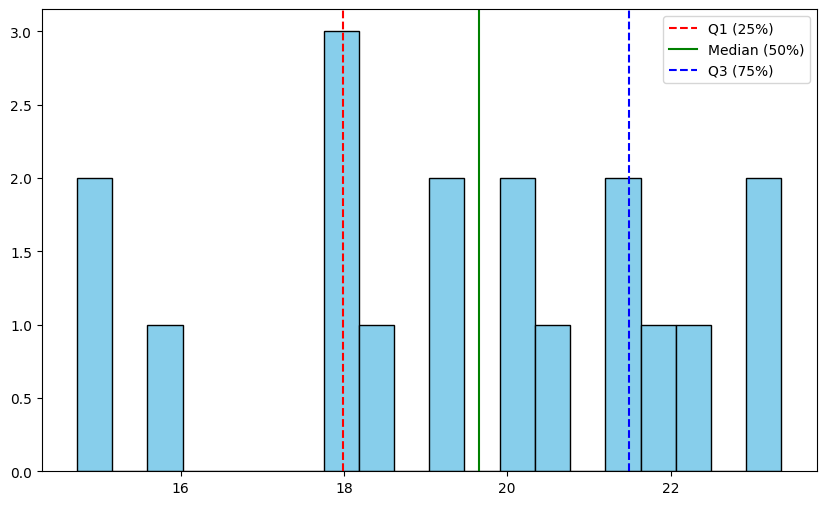

In [51]:
# Look into the distribution of the elderly population percentage by area
plt.figure(figsize=(10,6))
plt.hist(old_population_by_area['old_population_percentage'], bins = 20, color='skyblue', edgecolor='black')

# Add vertical lines for quartiles
q1_area, q2_area, q3_area = old_population_by_area['old_population_percentage'].quantile([0.25, 0.5, 0.75])
plt.axvline(q1_area, color='red', linestyle='--', label='Q1 (25%)')
plt.axvline(q2_area, color='green', linestyle='-', label='Median (50%)')
plt.axvline(q3_area, color='blue', linestyle='--', label='Q3 (75%)')

plt.legend()
plt.show()

In [52]:
# Check quartile values

print(f'''
Quartile Analysis:
- Q1 (25th percentile): {q1_area}
- Median (50th percentile): {q2_area}
- Q3 (75th percentile): {q3_area}
- Interquartile Range (IQR): {q3_area-q1_area}
''')


Quartile Analysis:
- Q1 (25th percentile): 17.990740150764335
- Median (50th percentile): 19.657063090592885
- Q3 (75th percentile): 21.488842115962278
- Interquartile Range (IQR): 3.498101965197943



In [ ]:
# Categorize the district needs into Low, High, Very High based on quartiles.
def categorize_area_need(row):
    """
    Categorize the district needs into Low, High, Very High based on quartiles.
    If the elderly population percentage is less than median, it is Low
    If the elderly population percentage is between median and Q3, it is High
    If the elderly population percentage is greater than Q3, it is Very High
    """
    if row['old_population_percentage'] < q2_area:
        return 'Low'
    elif row['old_population_percentage'] >= q3_area:
        return 'Very High'
    else:
        return 'High'

station_score['area_needs'] = station_score.apply(categorize_area_need, axis=1)
station_score

facility_category_en,station_no,station_code,station_name_en,area,old_population_percentage,hearing_impared_facility,mobility_impared_facility,visually_impaired_facilities,system_accessibility,total_facility_score,facility_score_category,area_needs,area_adjustment_score,accessibility_index
0,1,CEN,Central,Central and Western,19.279687,6,10,18,6,40,Medium,Low,-2,38
1,2,ADM,Admiralty,Central and Western,19.279687,8,10,17,8,43,High,Low,3,46
2,3,TST,Tsim Sha Tsui,Yau Tsim Mong,17.887828,6,9,20,8,43,High,Low,3,46
3,4,JOR,Jordan,Yau Tsim Mong,17.887828,6,8,18,6,38,Low,Low,-3,35
4,5,YMT,Yau Ma Tei,Yau Tsim Mong,17.887828,6,10,18,8,42,Medium,Low,-2,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,116,YUL,Yuen Long,Yuen Long,15.023051,6,10,18,10,44,High,Low,3,47
93,117,LOP,Long Ping,Yuen Long,15.023051,6,10,18,8,42,Medium,Low,-2,40
94,118,TIS,Tin Shui Wai,Yuen Long,15.023051,6,10,18,10,44,High,Low,3,47
95,119,SIH,Siu Hong,Tuen Mun,19.325125,6,10,18,11,45,High,Low,3,48


In [57]:
# Define area need adjustment score
def area_adjustment_score(row):
    """
    Adjust the facility score based on the area needs.
    """
    if row['facility_score_category'] == 'Low':
        if row['area_needs'] == 'Low':
            return -1
        elif row['area_needs'] == 'High':
            return -2
        else:
            return -3
    if row['facility_score_category'] == 'Medium':
        if row['area_needs'] == 'Low':
            return 0
        elif row['area_needs'] == 'High':
            return -1
        else:
            return -2
    if row['facility_score_category'] == 'High':
        if row['area_needs'] == 'Low':
            return 1
        elif row['area_needs'] == 'High':
            return 2
        else:
            return 3

station_score['area_adjustment_score'] = station_score.apply(area_adjustment_score, axis=1)
station_score
        

facility_category_en,station_no,station_code,station_name_en,area,old_population_percentage,hearing_impared_facility,mobility_impared_facility,visually_impaired_facilities,system_accessibility,total_facility_score,facility_score_category,area_needs,area_adjustment_score,accessibility_index
0,1,CEN,Central,Central and Western,19.279687,6,10,18,6,40,Medium,Low,0,38
1,2,ADM,Admiralty,Central and Western,19.279687,8,10,17,8,43,High,Low,1,46
2,3,TST,Tsim Sha Tsui,Yau Tsim Mong,17.887828,6,9,20,8,43,High,Low,1,46
3,4,JOR,Jordan,Yau Tsim Mong,17.887828,6,8,18,6,38,Low,Low,-1,35
4,5,YMT,Yau Ma Tei,Yau Tsim Mong,17.887828,6,10,18,8,42,Medium,Low,0,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,116,YUL,Yuen Long,Yuen Long,15.023051,6,10,18,10,44,High,Low,1,47
93,117,LOP,Long Ping,Yuen Long,15.023051,6,10,18,8,42,Medium,Low,0,40
94,118,TIS,Tin Shui Wai,Yuen Long,15.023051,6,10,18,10,44,High,Low,1,47
95,119,SIH,Siu Hong,Tuen Mun,19.325125,6,10,18,11,45,High,Low,1,48


In [58]:
station_score['accessibility_index'] = station_score['total_facility_score'] + station_score['area_adjustment_score']
station_score

facility_category_en,station_no,station_code,station_name_en,area,old_population_percentage,hearing_impared_facility,mobility_impared_facility,visually_impaired_facilities,system_accessibility,total_facility_score,facility_score_category,area_needs,area_adjustment_score,accessibility_index
0,1,CEN,Central,Central and Western,19.279687,6,10,18,6,40,Medium,Low,0,40
1,2,ADM,Admiralty,Central and Western,19.279687,8,10,17,8,43,High,Low,1,44
2,3,TST,Tsim Sha Tsui,Yau Tsim Mong,17.887828,6,9,20,8,43,High,Low,1,44
3,4,JOR,Jordan,Yau Tsim Mong,17.887828,6,8,18,6,38,Low,Low,-1,37
4,5,YMT,Yau Ma Tei,Yau Tsim Mong,17.887828,6,10,18,8,42,Medium,Low,0,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,116,YUL,Yuen Long,Yuen Long,15.023051,6,10,18,10,44,High,Low,1,45
93,117,LOP,Long Ping,Yuen Long,15.023051,6,10,18,8,42,Medium,Low,0,42
94,118,TIS,Tin Shui Wai,Yuen Long,15.023051,6,10,18,10,44,High,Low,1,45
95,119,SIH,Siu Hong,Tuen Mun,19.325125,6,10,18,11,45,High,Low,1,46


In [ ]:
#station_score.to_csv('data/processed/station_accessibility_index.csv', index=False)

# 4. Data visualization

## 4.1. Accessibility Index

#### 4.1.1. Statistics on accessibility index

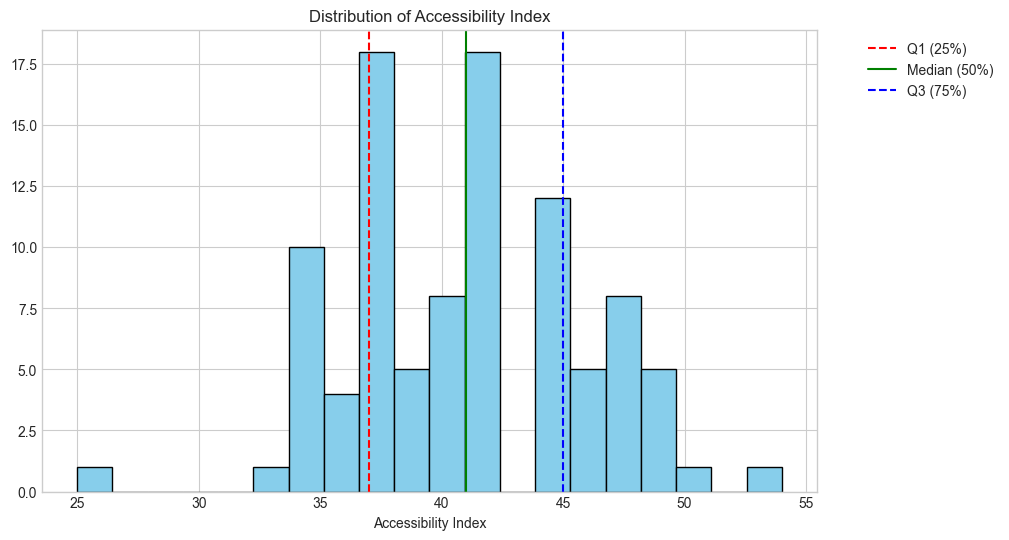

In [109]:
# Distribution of the accessibility index
plt.figure(figsize=(10,6))
plt.hist(station_score['accessibility_index'], bins = 20, color='skyblue', edgecolor='black')

# Add vertical lines for quartiles
q1_index, q2_index, q3_index = station_score['accessibility_index'].quantile([0.25, 0.5, 0.75])
plt.axvline(q1_index, color='red', linestyle='--', label='Q1 (25%)')
plt.axvline(q2_index, color='green', linestyle='-', label='Median (50%)')
plt.axvline(q3_index, color='blue', linestyle='--', label='Q3 (75%)')

plt.title('Distribution of Accessibility Index')
plt.xlabel('Accessibility Index')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('images/accessibility_index_distribution.png', dpi=300)
plt.show()

#### 4.1.2. Top and bottom stations in terms of accessibility index

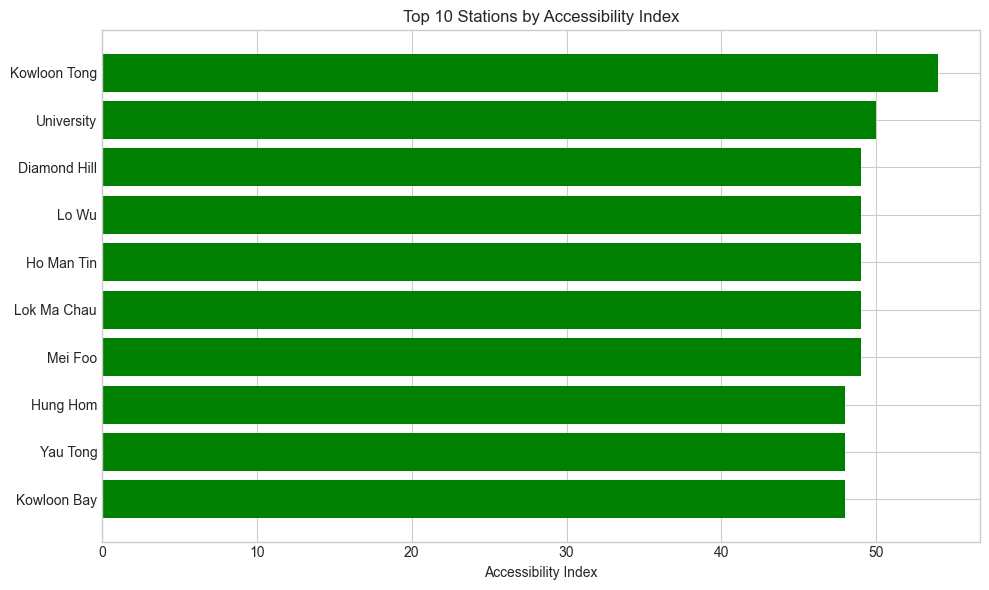

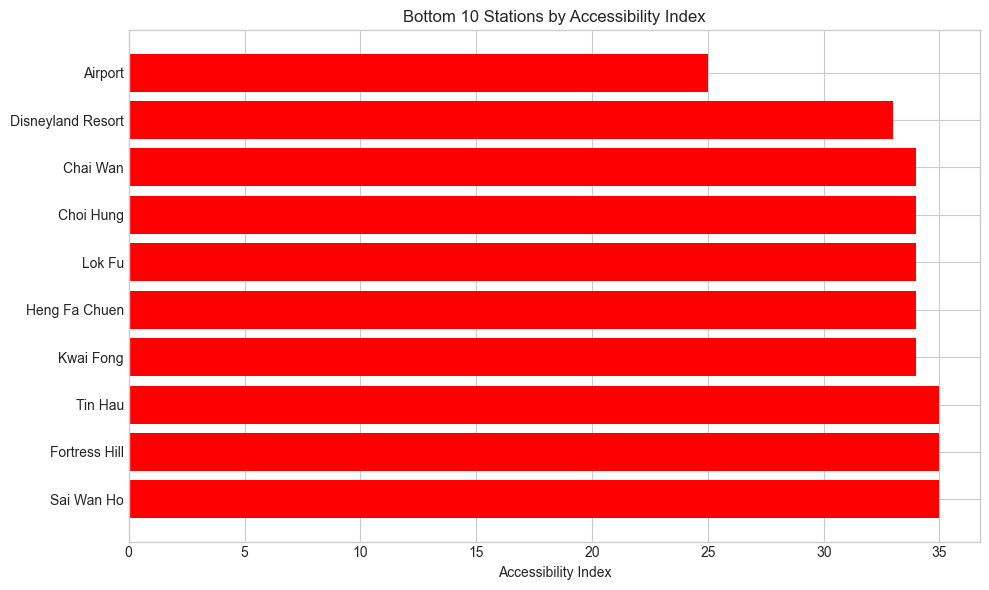

In [110]:
# Top 10 stations with highest accessibility index
top10 = station_score.nlargest(10, 'accessibility_index').sort_values('accessibility_index')

# Bottom 10 stations with lowest accessibility index
bottom10 = station_score.nsmallest(10, 'accessibility_index').sort_values('accessibility_index', ascending=False)

# ----- Top 10 Chart -----
plt.figure(figsize=(10, 6))
plt.barh(top10['station_name_en'], top10['accessibility_index'], color='green')
plt.title('Top 10 Stations by Accessibility Index')
plt.xlabel('Accessibility Index')
plt.tight_layout()
plt.savefig('images/top_10_accessibility.png', dpi=300)
plt.show()

# ----- Bottom 10 Chart -----
plt.figure(figsize=(10, 6))
plt.barh(bottom10['station_name_en'], bottom10['accessibility_index'], color='red')
plt.title('Bottom 10 Stations by Accessibility Index')
plt.xlabel('Accessibility Index')
plt.tight_layout()
plt.savefig('images/bottom_10_accessibility.png', dpi=300)
plt.show()


**Takeaway**
- Kowloon Tong, University, and Diamond Hill top the list, with the highest accessibility scores (near or above 50), suggesting these stations have strong infrastructure supporting inclusive access.
- On the other end, stations like Airport, Disneyland Resort, and Chai Wan rank lowest, with indices around 25–34, indicating significant room for improvement—even at major or high-traffic locations.
- The distribution reveals a noticeable disparity: no station scores above 55 or below 25, meaning most stations fall within a mid-range of accessibility, but even the best-performing stations are far from perfect.

#### 4.1.3. Percentage of accessibility category by district

- Categorize accessibility index into Low, Medium or High based on quartiles.
- Visualize the distribution of these index categories against district to identify districts that are in more urgent need to improve barrier-free facilities

In [111]:
# Create new category based on accessibility_index
def categorize_accessibility(row):
    """
    Categorize the accessibility index into Low, Medium, or High based on quartiles.
    If the index is less than median, it is Low
    If the index is between median and Q3, it is Medium
    If the index is greater than Q3, it is High
    """
    if row['accessibility_index'] < q2_index:
        return 'Low'
    elif row['accessibility_index'] >= q3_index:
        return 'High'
    else:
        return 'Medium'

station_score['accessibility_category'] = station_score.apply(categorize_accessibility, axis = 1)

# Group by area and category, then get percentage
area_category_counts = station_score.groupby(['area', 'accessibility_category']).size().unstack(fill_value=0)
area_category_pct = area_category_counts.div(area_category_counts.sum(axis=1), axis=0) * 100

# Reorder the categories to Low, Medium, High
area_category_pct = area_category_pct[['Low', 'Medium', 'High']]

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_32252\123557220.py:2: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  area_category_pct.sort_index().plot(
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_32252\123557220.py:2: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  area_category_pct.sort_index().plot(


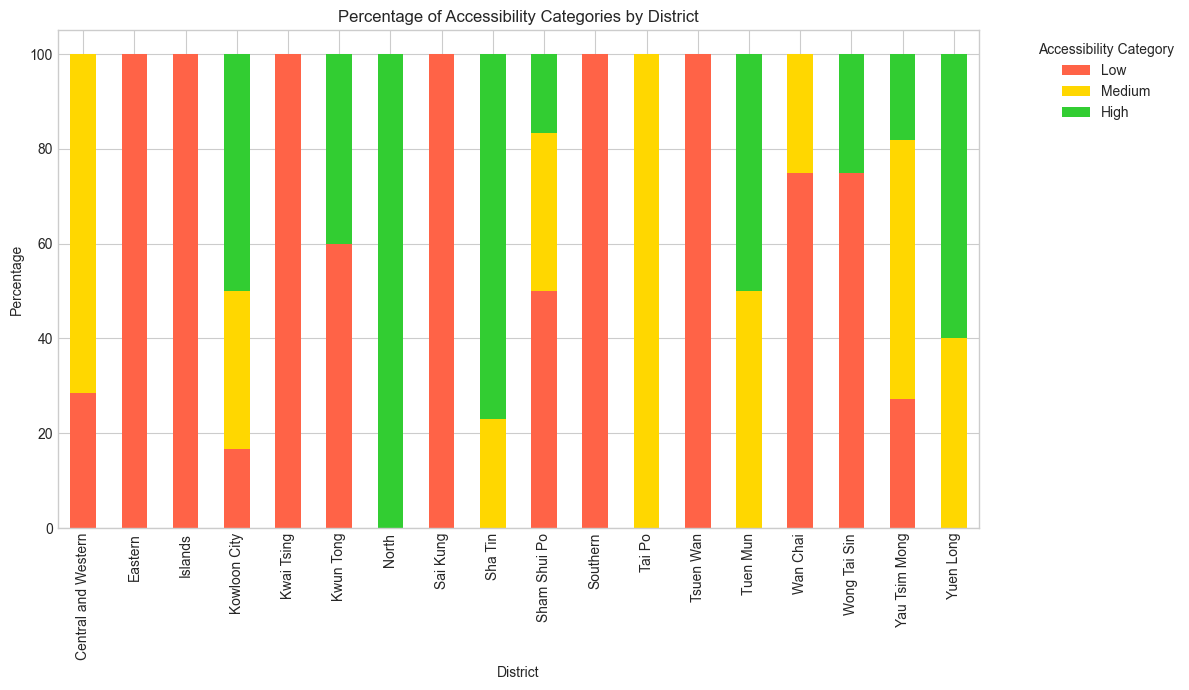

In [ ]:
area_category_pct.sort_index().plot(
    kind='bar',
    stacked=True,
    figsize=(12, 7),
    colormap='Set2',
    color=['#FF6347', '#FFD700', '#32CD32']
)

plt.title('Percentage of Accessibility Categories by District')
plt.ylabel('Percentage')
plt.xlabel('District')
plt.legend(title='Accessibility Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('images/accessibility_by_district.png', dpi=300)
plt.show()

**Takeaways**
- Several districts, including Kwun Tong, North, Sha Tin, Tuen Mun, and Yuen Long, have 100% of their stations in the “Low” category, highlighting regions where accessibility is most lacking.
- In contrast, Central & Western and Wong Tai Sin are the only districts with any “High” accessibility stations, suggesting isolated examples of good design but no district-wide consistency.
- Most districts contain a mix of accessibility levels, which could indicate uneven investment in infrastructure or legacy systems that haven't been updated evenly.
- The absence of any district with majority “High” accessibility shows there is no clear accessibility leader in the network

#### 4.1.4. Prioritization of stations

Priority is set based on the following framework:

![](images/index_prioritization_framework.png)

In [113]:
# Set priority level for barrier-free facility improvement
def set_priority(row):
    """
    Set priority level for barrier-free facility improvement based on facility score category and area needs.
    """
    if (row['facility_score_category'] == 'Low' and row['area_needs'] == ('Very High' or 'High')) or \
        (row['facility_score_category'] == 'Medium' and row['area_needs'] == 'Very High'):
        return 'High'
    elif (row['facility_score_category'] == 'Medium' and row['area_needs'] == 'High') or \
        (row['facility_score_category'] == 'Low' and row['area_needs'] == 'Low'):
        return 'Medium'
    else:
        return 'Low'

station_score['priority_level'] = station_score.apply(set_priority, axis=1)


# Group by area and priority, then get percentage
area_priority_counts = station_score.groupby(['area', 'priority_level']).size().unstack(fill_value=0)
area_priority_pct = area_priority_counts.div(area_priority_counts.sum(axis=1), axis=0) * 100

# Reorder the categories to Low, Medium, High
area_priority_pct = area_priority_pct[['High', 'Medium', 'Low']]

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_32252\183917444.py:2: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  area_priority_pct.sort_index().plot(
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_32252\183917444.py:2: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  area_priority_pct.sort_index().plot(


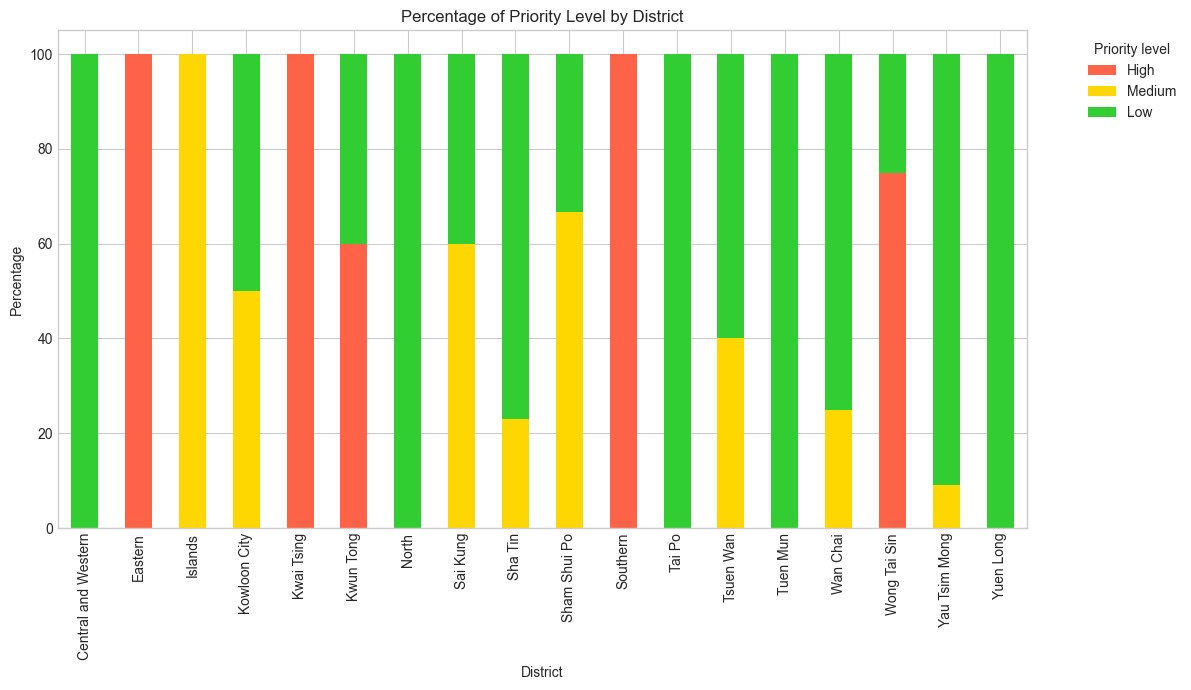

In [ ]:
area_priority_pct.sort_index().plot(
    kind='bar',
    stacked=True,
    figsize=(12, 7),
    colormap='Set2',
    color=['#FF6347', '#FFD700', '#32CD32']
)

plt.title('Percentage of Priority Level by District')
plt.ylabel('Percentage')
plt.xlabel('District')
plt.legend(title='Priority level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('images/priority_by_district.png', dpi=300)
plt.show()

**Takeaways**
- This chart organizes districts by the urgency of accessibility improvements, based on how poorly stations perform and possibly how essential they are to local demographics.
- Districts such as Islands, Kwai Tsing, Southern, and Wong Tai Sin have a significant share of “High” priority stations, marking them as urgent targets for infrastructure upgrades.
- On the other hand, districts like North, Tai Po, Tuen Mun, and Yuen Long have all stations in the “Low” priority group, either because their accessibility needs are less severe or improvements are less urgent.
- Medium priority dominates many central and residential districts (e.g., Kowloon City, Sha Tin, Tsuen Wan), indicating these areas may benefit from phased or opportunistic improvements.

## 4.2. Facility Score

### 4.2.1. Score comparison among facility type

In [ ]:
facility_cols = [
    'hearing_impared_facility', 
    'visually_impaired_facility', 
    'mobility_impared_facility', 
    'system_accessibility'
]

# Define the max score for each facility
max_scores = {
    'hearing_impared_facility': 10,
    'visually_impaired_facility': 21,
    'mobility_impared_facility': 17,
    'system_accessibility': 22
}

# Calculate total facility score and normalize using max scores
facility_df = station_score[facility_cols].sum().to_frame(name='total')
facility_df['max_possible'] = [max_scores[col] * len(station_score) for col in facility_cols]
facility_df['normalized_percent'] = (facility_df['total'] / facility_df['max_possible']) * 100


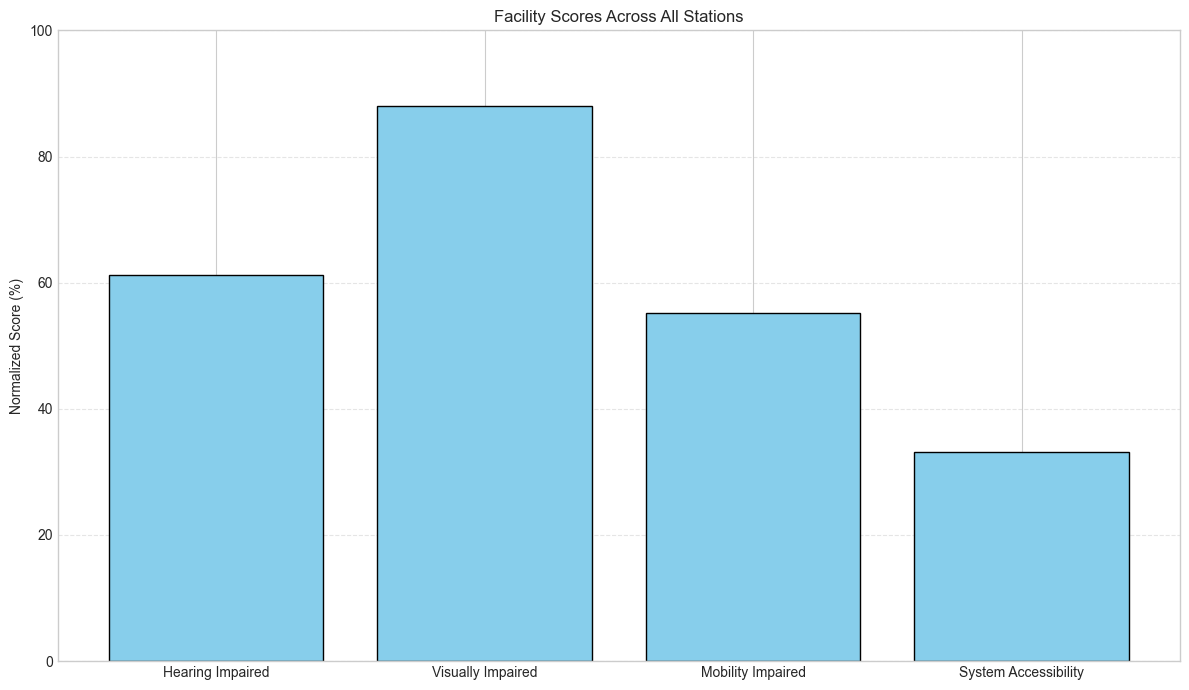

In [ ]:
plt.figure(figsize=(12, 7))
plt.bar(
    facility_df.index,
    facility_df['normalized_percent'],
    color='skyblue',
    edgecolor='black'
)

x_labels = [
    'Hearing Impaired',
    'Visually Impaired',
    'Mobility Impaired',
    'System Accessibility'
]
plt.xticks(ticks=range(len(x_labels)), labels=x_labels, rotation=0)

plt.ylabel('Normalized Score (%)')
plt.title('Facility Scores Across All Stations')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('images/facility_score_overall.png', dpi=300)
plt.show()


**Takeaways**

- Despite having the highest number of items categorized as "Highly Important," the System Accessibility score ranks the lowest, highlighting a significant concern for the elderly and disabled populations. This indicates that the overall system's infrastructure remains largely inadequate in addressing the needs of passengers with mobility challenges.
- The category of "Mobility Impaired Facilities" follows closely behind with the second lowest score, further emphasizing the difficulties faced by elderly passengers in their daily commutes.

### 4.2.2. Facility score comparison among districts with high number of high-priority stations

In [143]:
selected_areas = ['Eastern', 'Kwai Tsing', 'Southern', 'Wong Tai Sin']
filtered_areas = station_score[station_score['area'].isin(selected_areas)].copy()

# Calculate total and max possible per district
grouped_total = filtered_areas.groupby('area')[facility_cols].sum()
station_counts = filtered_areas.groupby('area').size()

# Normalize scores
normalized_data = []
for col in facility_cols:
    max_possible = max_scores[col] * station_counts
    normalized = (grouped_total[col] / max_possible) * 100
    normalized_data.append(normalized)

filtered_areas = pd.DataFrame(normalized_data, index=facility_cols).T

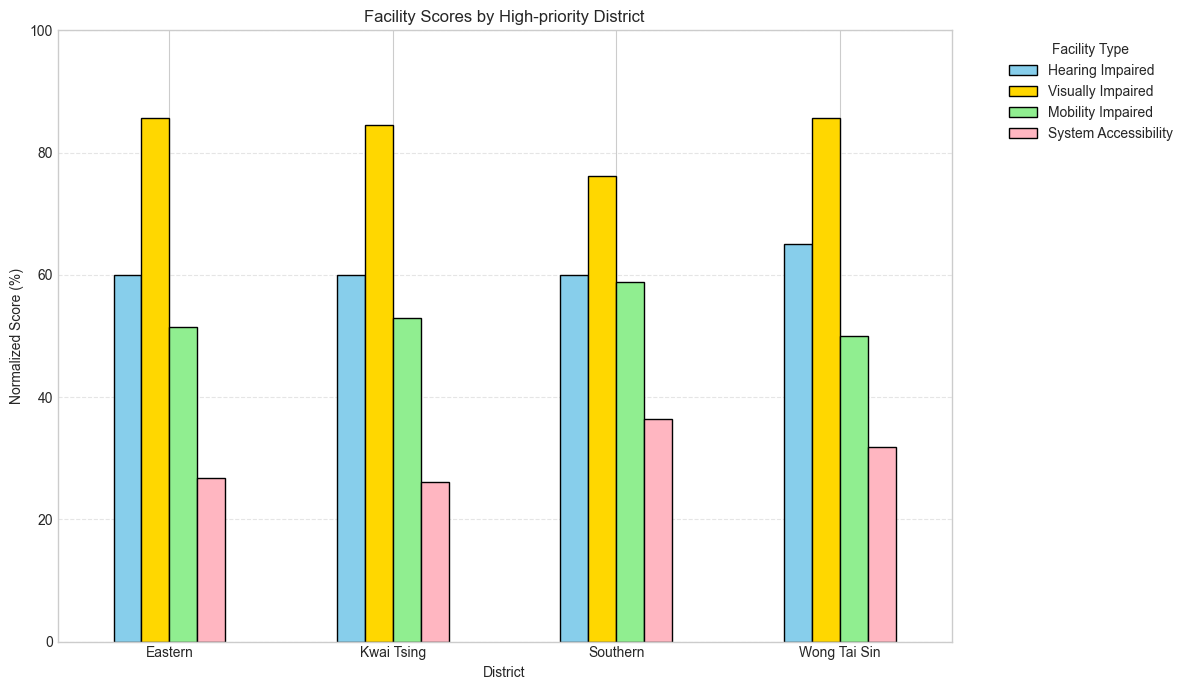

In [145]:
filtered_areas.plot(kind='bar', 
                    figsize=(12, 7),
                    color=['#87CEEB', '#FFD700', '#90EE90', '#FFB6C1'], 
                    edgecolor='black')

plt.xticks(rotation=0)
plt.xlabel('District')
plt.ylabel('Normalized Score (%)')
plt.title('Facility Scores by High-priority District')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title='Facility Type', labels=x_labels, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('images/facility_score_selected.png', dpi=300)
plt.show()

**Takeaways**
- Similar to the overall trend, the four most challenged districts show significant shortcomings in System Accessibility facilities. This issue is particularly alarming in Kwai Tsing, where the elderly population percentage is one of the highest, yet the district's System Accessibility score is the lowest. 
